# 

# Mini Project III - Twitter US Airline Sentiment Analysis

## With Combined TF-IDF Vectors as features and Text/NLP

### Import libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import spacy
import regex as re
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

#### Load data

In [2]:
## Loading the data
df = pd.read_csv('./Data/Tweets.csv')
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## EDA

#### Inspect the data

- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
  
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)


In [3]:
df.shape

(14640, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

###### Check for **Null** values 

In [5]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

###### Drop Columns with more than 50% null values and unrelateed features for sentiment analysis

In [6]:
df_tweet=df.drop(['tweet_id' ,'airline_sentiment_confidence','negativereason_confidence','name','airline_sentiment_gold', 'negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'], axis = 1)

In [7]:
df_tweet.head()

,airline_sentiment,negativereason,airline,text
0,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...


In [8]:
# # Drop Null values in Negative reason
# df_tweet= df_tweet.dropna(axis=0, subset=['negativereason'])

In [9]:
df_tweet.isnull().sum()

airline_sentiment       0
negativereason       5462
airline                 0
text                    0
dtype: int64

###### Check for **Zero** values 

In [10]:
df_tweet.isin([0]).sum()

airline_sentiment    0
negativereason       0
airline              0
text                 0
dtype: int64

###### check for value counts in each column

In [11]:
df_tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [12]:
df_tweet['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [13]:
df_tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [14]:
# Select Data for Sentiment Analysis
df_tweet['airline_sentiment'] = df_tweet['airline_sentiment'].replace(['negative','neutral','positive'],[-1,0,1])                

In [15]:
df_tw=df_tweet.drop(['airline','negativereason'], axis = 1)

In [16]:
# ANSWER
df_tw.head()

,airline_sentiment,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


In [17]:
df_tw.tail()

,airline_sentiment,text
14635,1,@AmericanAir thank you we got on a different f...
14636,-1,@AmericanAir leaving over 20 minutes Late Flig...
14637,0,@AmericanAir Please bring American Airlines to...
14638,-1,"@AmericanAir you have my money, you change my ..."
14639,0,@AmericanAir we have 8 ppl so we need 2 know h...


In [18]:
df_tw.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [19]:
df_tw.shape

(14640, 2)

###### Data Cleaning for Analysis

###### Step 1 - Clean text

In [20]:
def clean_text(text):

    # remove double quotes
    text = re.sub(r'"', '', text)
    # remove @username 
    text = re.sub(r'@[\w]*','',text)
    # remove special characters, numbers, punctuations
    text = re.sub(r'[^a-zA-Z#]', ' ', text)
    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ' , text)
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)

    return text

In [21]:
# Clean Data
df_tw['text'] = df_tw['text'].apply(clean_text)

In [22]:
df_tw['text'].head(10)

0                                          What  said 
1     plus you ve added commercials to the experien...
2     didn today    Must mean need to take another ...
3     it really aggressive to blast obnoxious enter...
4               and it a really big bad thing about it
5     seriously would pay flight for seats that did...
6     yes  nearly every time fly VX this  ear worm ...
7     Really missed prime opportunity for Men Witho...
8                            Well didn but NOW DO    D
9     it was amazing  and arrived an hour early  Yo...
Name: text, dtype: object

###### Step 2 - Remove stop words, puctuations and  perform lemmatization

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
# remove stop words, puctuations and  perform lemmatization
def convert_text(text):
    '''
    Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.
    '''
    doc = nlp(text)
    t = [w for w in doc if not (w.is_stop | w.is_punct)]
    x = [w.lemma_.lower() for w in t]

    s= " ".join(x)

    return s

In [25]:
%%time
df_tw['text'] = df_tw['text'].apply(convert_text)

Wall time: 1min 16s


In [26]:
df_tw['text'].head(10)

0                                                  say
1          plus ve add commercial experience     tacky
2                        didn today     mean need trip
3      aggressive blast obnoxious entertainment gue...
4                                        big bad thing
5      seriously pay flight seat didn play   bad th...
6      yes   nearly time fly vx   ear worm   win aw...
7      miss prime opportunity man hats parody     h...
8                                           didn     d
9                   amazing   arrive hour early   good
Name: text, dtype: object

## Feature Engineering

### Text / NLP based features

Create some other features.

Char_Count = Number of Characters in Text

Word Count = Number of Words in Text

Word Density = Average Number of Char in Words

Punctuation Count = Number of Punctuation in Text

Title Word Count = Number of Words in Title

Uppercase Word Count = Number of Upperwords in Text

In [27]:
def count_num(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "NOUN":
            count+=1
            
    return count

def adj_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "ADJ":
            count+=1
            
    return count

def adv_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "ADV":
            count+=1
            
    return count

def propn_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "PRON":
            count+=1
            
    return count

def num_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "NUM":
            count+=1
            
    return count

def pron_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "PROPN":
            count+=1
            
    return count

def verb_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "VERB":
            count+=1
            
    return count

def sym_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "SYM":
            count+=1
            
    return count

In [28]:
%%time
# New Features

df_tw['char_count'] = df_tw['text'].apply(len)
df_tw['word_count'] = df_tw['text'].apply(lambda x: len(x.split()))
df_tw['word_density'] = df_tw['char_count'] / (df_tw['word_count']+1)
df_tw['punctuation_count'] = df_tw['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
# df_tw['title_word_count'] = df_tw['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

Wall time: 116 ms


In [29]:
# Adding new features (pos)
df_tw['noun_count'] = df_tw['text'].apply(count_num)
df_tw['adj_count'] = df_tw['text'].apply(adj_count)
df_tw['adv_count'] = df_tw['text'].apply(adv_count)
df_tw['num_count'] = df_tw['text'].apply(num_count)
df_tw['pron_count'] = df_tw['text'].apply(pron_count)
df_tw['propn_count'] = df_tw['text'].apply(propn_count)
df_tw['verb_count'] = df_tw['text'].apply(verb_count)
df_tw['sym_count'] = df_tw['text'].apply(sym_count)

In [30]:
df_tw.head()

,airline_sentiment,text,char_count,word_count,word_density,punctuation_count,noun_count,adj_count,adv_count,num_count,pron_count,propn_count,verb_count,sym_count
0,0,say,7,1,3.500000,0,0,0,0,0,0,0,1,0
1,1,plus ve add commercial experience tacky,45,6,6.428571,0,1,1,1,0,0,0,1,0
2,0,didn today mean need trip,31,5,5.166667,0,2,0,0,0,1,0,2,0
3,-1,aggressive blast obnoxious entertainment gue...,79,9,7.900000,0,4,3,0,0,1,0,1,0
4,-1,big bad thing,15,3,3.750000,0,1,2,0,0,0,0,0,0


In [31]:
features = ['char_count','word_count','word_density','punctuation_count','noun_count','adj_count','adv_count','num_count','pron_count','propn_count','verb_count','sym_count']

### TF-IDF Vectors as features

In [32]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
tfidf=tfidf_vect.fit_transform(df_tw['text']).toarray()
text_vect = pd.DataFrame(tfidf)

Wall time: 183 ms


## Split the data into train and test

In [33]:
# Features and Labels
# merge all created features
X = pd.merge(text_vect,df_tw[features],left_index=True, right_index=True)
y = df_tw['airline_sentiment']
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
X_train.shape

(11712, 5012)

In [35]:
y_train.shape

(11712,)

In [36]:
y_test.shape

(2928,)

In [37]:
X_test.shape

(2928, 5012)

## Modelling

In [38]:
# Model evaluation function
def evaluate_model(classifier, feature_vector_train, label_train, feature_vector_test,label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict accuracy
    print(f" Accuracy Score for train data = {classifier.score(feature_vector_train, label_train)}")
    print(f" Accuracy Score for test data = {classifier.score(feature_vector_test, label_test)}")
    
    
    # confusion matrix
    log_cm = metrics.confusion_matrix(label_test, predictions,[-1,0,1])
    sns.heatmap(log_cm, annot=True, fmt='.2f',xticklabels = ["Negative","Neutral", "Positive"] , yticklabels = ["Negative","Neutral", "Positive"],cmap='Blues' )
    plt.title('Confusion Matrics')
    plt.savefig('cm')
    
   
    # Classification Report for test data
    print("Classification Report for test data")
    print(classification_report(label_test, predictions))
    
    return classifier.score(feature_vector_test, label_test)

In [39]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['WordLevel TF-IDF'])

### Naive Bayes Classifier

In [40]:
%%time
mnb_model = MultinomialNB()
mnb_model.fit( X_train, y_train)
# Score

print(f" Accuracy Score for train data = {mnb_model.score(X_train, y_train)}")
print(f" Accuracy Score for test data = {mnb_model.score(X_test , y_test)}")

 Accuracy Score for train data = 0.7318135245901639
 Accuracy Score for test data = 0.7151639344262295
Wall time: 879 ms


#### Naive Bayes Classifier Hyperparameter tuning on count vectors

In [41]:
nvb_params = {
    'fit_prior': [True, False],
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
nvb=MultinomialNB()
nvb_cv=GridSearchCV(nvb,nvb_params, cv=5, verbose=0)
best_model = nvb_cv.fit(X_train,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T


,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.387522,0.402862,0.401958,0.393953,0.387191,0.398728,0.390982,0.394249,0.414637,0.401284
std_fit_time,0.015638,0.010437,0.013363,0.011302,0.026011,0.006419,0.004724,0.011615,0.010687,0.014178
mean_score_time,0.105621,0.101622,0.09042,0.091817,0.101219,0.090722,0.095822,0.101054,0.104495,0.11176
std_score_time,0.014417,0.009137,0.008595,0.008082,0.010851,0.009779,0.013307,0.007734,0.014031,0.003466
param_alpha,0.01,0.01,0.1,0.1,0.5,0.5,1.0,1.0,10.0,10.0
param_fit_prior,True,False,True,False,True,False,True,False,True,False
params,"{'alpha': 0.01, 'fit_prior': True}","{'alpha': 0.01, 'fit_prior': False}","{'alpha': 0.1, 'fit_prior': True}","{'alpha': 0.1, 'fit_prior': False}","{'alpha': 0.5, 'fit_prior': True}","{'alpha': 0.5, 'fit_prior': False}","{'alpha': 1.0, 'fit_prior': True}","{'alpha': 1.0, 'fit_prior': False}","{'alpha': 10.0, 'fit_prior': True}","{'alpha': 10.0, 'fit_prior': False}"
split0_test_score,0.7277,0.701238,0.737089,0.705079,0.721724,0.719163,0.695689,0.724712,0.622279,0.622279
split1_test_score,0.727273,0.708067,0.735382,0.711908,0.722578,0.735809,0.697823,0.7277,0.622279,0.622279
split2_test_score,0.728864,0.706234,0.740393,0.70538,0.719471,0.715628,0.69257,0.712212,0.622545,0.622545


 Accuracy Score for train data = 0.823941256830601
 Accuracy Score for test data = 0.755464480874317


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.79      0.92      0.85      1889
           0       0.57      0.39      0.46       580
           1       0.76      0.54      0.63       459

    accuracy                           0.76      2928
   macro avg       0.71      0.62      0.65      2928
weighted avg       0.74      0.76      0.74      2928

Wall time: 1.32 s


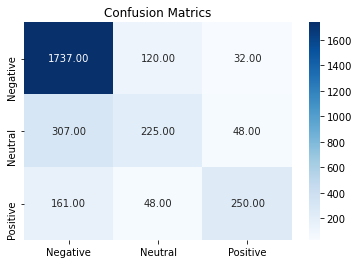

In [42]:
%%time
accuracy1 = evaluate_model(MultinomialNB(alpha = 0.1, fit_prior= True), X_train, y_train,X_test , y_test)

In [43]:
results.loc['Naïve Bayes'] = {
    'WordLevel TF-IDF': accuracy1}

### Linear Classifier

In [44]:
model = LogisticRegression(solver='liblinear')
# Fit Model
model.fit(X_train,y_train)
# Score

print(f" Accuracy Score for train data = {model.score(X_train, y_train)}")
print(f" Accuracy Score for test data = {model.score(X_test , y_test)}")

 Accuracy Score for train data = 0.8288080601092896
 Accuracy Score for test data = 0.7814207650273224


#### Linear Classifier Hyperparameter tuning 

In [45]:
# use GridSearchCV to find best hyper parameters

In [46]:
lr_params = {'penalty': ['l1','l2'],'C': [0.001,0.1,1, 10, 100]}

logreg=LogisticRegression(max_iter=10000,solver='liblinear')
logreg_cv=GridSearchCV(logreg,lr_params, cv=5, verbose=0)
best_model = logreg_cv.fit(X_train,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.95557,0.916413,1.123416,1.014406,1.807942,1.088622,2.590995,1.134482,2.106167,1.304383
std_fit_time,0.047932,0.014685,0.011958,0.012213,0.088589,0.037321,0.456728,0.035471,0.184497,0.031635
mean_score_time,0.087337,0.08285,0.075514,0.073855,0.07001,0.079166,0.07401,0.078512,0.073623,0.069712
std_score_time,0.005844,0.003454,0.002653,0.002323,0.001096,0.009006,0.003748,0.008706,0.003768,0.000866
param_C,0.001,0.001,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1, 'penalty': 'l1'}","{'C': 1, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.622279,0.626974,0.703372,0.703372,0.769526,0.769953,0.753735,0.769526,0.697823,0.741784
split1_test_score,0.622279,0.644046,0.714042,0.719163,0.769953,0.779343,0.73837,0.771233,0.691848,0.734102
split2_test_score,0.622545,0.636635,0.705807,0.707088,0.757472,0.762169,0.743809,0.765158,0.700256,0.734415


 Accuracy Score for train data = 0.9055669398907104
 Accuracy Score for test data = 0.79474043715847


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.84      0.91      0.87      1889
           0       0.62      0.52      0.57       580
           1       0.77      0.66      0.71       459

    accuracy                           0.79      2928
   macro avg       0.74      0.70      0.72      2928
weighted avg       0.79      0.79      0.79      2928

Wall time: 1.96 s


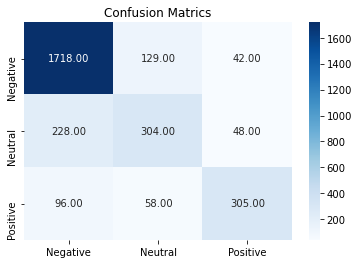

In [61]:
%%time
accuracy1 = evaluate_model(LogisticRegression(C=10, penalty='l2',solver='liblinear'), X_train, y_train,X_test , y_test)

In [48]:
results.loc['Logistic Regression'] ={
    'WordLevel TF-IDF': accuracy1}

### Support Vector Machine

C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


 Accuracy Score for train data = 0.8090846994535519
 Accuracy Score for test data = 0.7537568306010929


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.77      0.95      0.85      1889
           0       0.59      0.40      0.48       580
           1       0.89      0.40      0.55       459

    accuracy                           0.75      2928
   macro avg       0.75      0.58      0.63      2928
weighted avg       0.75      0.75      0.73      2928

Wall time: 3.55 s


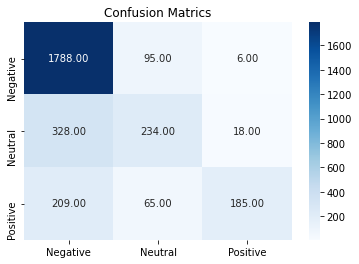

In [49]:
%%time
accuracy1 = evaluate_model(LinearSVC(), X_train, y_train,X_test , y_test)

In [50]:
results.loc['Support Vector Machine'] = {
    'WordLevel TF-IDF': accuracy1,}

### Bagging Models

In [51]:
%%time
modelrwf = RandomForestClassifier(n_estimators = 100)
modelrwf.fit( X_train,y_train)

print(f" Accuracy Score for train data = {modelrwf.score( X_train , y_train)}")
print(f" Accuracy Score for test data = {modelrwf.score(X_test, y_test)}")

 Accuracy Score for train data = 0.9948770491803278
 Accuracy Score for test data = 0.7517076502732241
Wall time: 31.5 s


##### Hyperparameter tuning On Word Level TF IDF Vectors

In [52]:
param_grid = {
    'max_depth': [70,80,100],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [10,50, 100,150,200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the random search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 100}

 Accuracy Score for train data = 0.9947916666666666
 Accuracy Score for test data = 0.7527322404371585
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.77      0.93      0.85      1889
           0       0.61      0.35      0.45       580
           1       0.76      0.51      0.61       459

    accuracy                           0.75      2928
   macro avg       0.71      0.60      0.63      2928
weighted avg       0.74      0.75      0.73      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 1min 1s


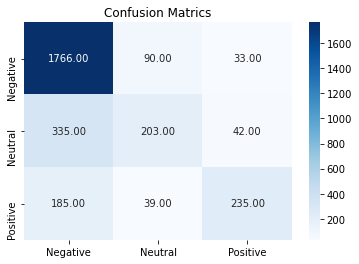

In [53]:
%%time
accuracy1 = evaluate_model(RandomForestClassifier( min_samples_leaf=1,min_samples_split=3, n_estimators=200), X_train, y_train,X_test , y_test)

In [54]:
results.loc['Random Forest'] = {
    'WordLevel TF-IDF': accuracy1}

### Boosting Models

In [55]:
%%time
modelgf = GradientBoostingClassifier()
modelgf.fit( X_train,y_train)

print(f" Accuracy Score for train data = {modelgf.score( X_train , y_train)}")
print(f" Accuracy Score for test data = {modelgf.score(X_test, y_test)}")

 Accuracy Score for train data = 0.7627219945355191
 Accuracy Score for test data = 0.7472677595628415
Wall time: 2min 48s


In [57]:
# parameters = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[1,3,5,7,9],
#     "learning_rate":[0.01,0.1,1,10,100]
# }

# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the Random search model
# grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 2)
# best_model = grid_search.fit(X_train,y_train)
# grid_search.best_params_

 Accuracy Score for train data = 0.764771174863388
 Accuracy Score for test data = 0.7503415300546448


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.78      0.92      0.84      1889
           0       0.59      0.34      0.43       580
           1       0.72      0.57      0.64       459

    accuracy                           0.75      2928
   macro avg       0.70      0.61      0.64      2928
weighted avg       0.73      0.75      0.73      2928

Wall time: 2min 48s


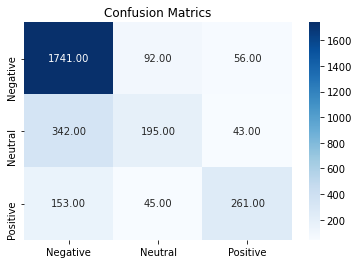

In [58]:
%%time
accuracy1 = evaluate_model(GradientBoostingClassifier(), X_train, y_train,X_test , y_test)

In [59]:
results.loc['Gradient Boosting'] = {
    'WordLevel TF-IDF': accuracy1}

In [60]:
results

,WordLevel TF-IDF
Naïve Bayes,0.755464
Logistic Regression,0.723019
Support Vector Machine,0.753757
Random Forest,0.752732
Gradient Boosting,0.750342


In [ ]:
# Sentiment can predit with 76% accuracy with svm algorithem  with TF-IDF and Text/NLP

#### Summary

- Sentiment Analysis can be predicted with 76 % accuracy with SVM.
- Virgin America has the highest percentage(30%) of positive sentiment as well as lowest negative sentiment percentage(36%). Based on public opinion Virgin America perform the best out of all US  airlines followed by Delta airline.
- US Airline has the highest percentage(78%) of Negative sentiment followed by American airline. Both airlines can categories as high risk of having customer churn over  based on tweets.
- Customer service issues are the most common negative reason among all airlines.
- US airlines and United airlines have relatively high negative sentiment due to late flights.
- United has the highest negative sentiment due to lost luggage.
- Based on public sentiment, Virgin America perform the best out of all US  airlines followed by Delta airline.
